#  通用题目

## 1.1 环境配置

2022-07-26 18:23:11.981087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 18:23:11.981104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-26 18:23:13.460975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-26 18:23:13.460992: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 18:23:13.461002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (imasonliu-LC4): /proc/driver/nvidia/version does not exist
2022-07-26 18:23:13.461158: I tensorflow/core/platform/cpu_feat

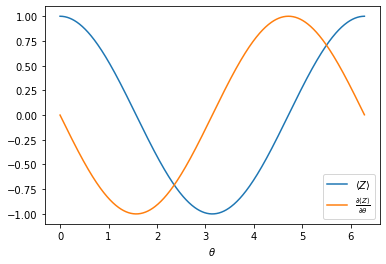

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorcircuit as tc

K = tc.set_backend("tensorflow")


@K.jit
def exp_z(param):
    c = tc.Circuit(1)
    c.rx(0, theta=param)
    return K.real(c.expectation_ps(z=[0]))


grad_z = K.grad(exp_z)

params = K.convert_to_tensor(np.arange(0, 2 * np.pi, 0.01))

plt.plot(params, [exp_z(param) for param in params], label=r"$\langle Z\rangle$")
plt.plot(
    params,
    [grad_z(param) for param in params],
    label=r"$\frac{\partial \langle Z\rangle}{\partial \theta}$",
)
plt.legend()
plt.xlabel(r"$\theta$")
plt.show()

## 1.2向量和矩阵

### 1.2.1矩阵旋转

In [3]:
import math
import numpy as np 

theta = 1
A = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])

B = np.array([1, 0])

np.matmul(A, B)

array([ 0.54030231, -0.84147098])

### 1.2.2矩阵指数

In [14]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np

K = tc.set_backend("tensorflow")

X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix
I = np.array([[1, 0],[0,1]])

P = X*1j
a = K.expm(P)
print(a)

theta = 1
b = K.expm(P*theta)
c = I*math.cos(theta) + P*math.sin(theta)
d = b-c
print(d)

tf.Tensor(
[[0.54030231+0.j         0.        +0.84147098j]
 [0.        +0.84147098j 0.54030231+0.j        ]], shape=(2, 2), dtype=complex128)
tf.Tensor(
[[ 0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -1.11022302e-16+0.j]], shape=(2, 2), dtype=complex128)


### 1.2.3矩阵关于向量的期望

/home/tencent_go/anaconda3/envs/tc/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


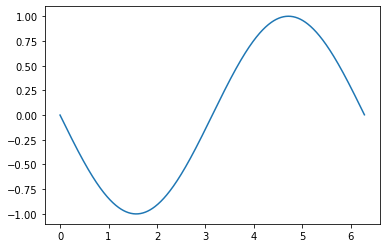

In [14]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

K = tc.set_backend("tensorflow")

X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix
P = X*1j
Q = Y

def func(theta):
    v_0 = np.array([[1, 0]])
    v = v_0 @ K.expm((P*theta)/2)
    A = K.transpose(K.conj(v))
    E = v @ Q @ A
    return E[0,0]

theta_list = np.arange(0, 2 * np.pi, 0.01)
plt.plot(theta_list, [func(theta) for theta in theta_list])
plt.show()

### 1.2.4张量积

In [24]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

n = 3
X = tc.gates._x_matrix 
Z = tc.gates._z_matrix
H = np.zeros((2**n,2**n))
for i in range(n):
    H +=np.kron(np.kron(np.identity(2**i),Z),np.identity(2**(n-i-1)))
for i in range(n-1):
    H +=np.kron(np.kron(np.identity(2**i),X),np.identity(2**(n-i-1)))*np.kron(np.kron(np.identity(2**(i+1)),X),np.identity(2**(n-i-2)))

print(H)
print(H[0,0])

[[ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -3.]]
3.0


### 1.2.5狄拉克符号

In [6]:
import math
import numpy as np

a = np.array([[0,
               0,
              1,
              0,
              0,
              0,
              0,
              0]])
b = np.array([[0,
               0,
              0,
              0,
              0,
              1,
              0,
              0]])
c = (a-b)/math.sqrt(2)
print(c)

[[ 0.          0.          0.70710678  0.          0.         -0.70710678
   0.          0.        ]]


## 1.3导数与梯度下降

### 1.3.1数值微分

In [5]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return x**2

y=0.00001
for x in range(5):
    a = (f(x+y)-f(x))/y
    print(a)

1e-05
2.00001000001393
4.000010000027032
6.000009999951316
8.00000999952033


### 1.3.2三角函数数值微分

$$f(x)=A\sin(x+B)+C$$
$$则f'(x)=A\cos(x+B)$$
$$f'(x)=\frac {f(x+\delta )-f(x- \delta )}{\tau}=\frac {A[sin(x+B+\delta )-sin(x+B- \delta )]}{\tau}$$
$$=\frac {2A\cos(x+B)sin(\delta )}{\tau}$$
$$发现当\tau=2\sin(\delta)时，存在严格的数值差分和解析导数相同$$

### 1.3.3单比特参数平移

已知：$\hat{P_1},\hat{P_2},\hat{P_3}分别为X，Y，Z三个泡利矩阵$
$$e^{-i\frac{\theta}{2}\hat{P_1}}=\cos(-\frac{\theta}{2})I+i\sin(-\frac{\theta}{2})\hat{P_1}$$
$$e^{i\frac{\theta}{2}\hat{P_1}}=\cos(\frac{\theta}{2})I+i\sin(\frac{\theta}{2})\hat{P_1}$$
故：$$e^{-i\frac{\theta}{2}\hat{P_1}}\hat{P_2}e^{i\frac{\theta}{2}\hat{P_1}}=[\cos(-\frac{\theta}{2})I+i\sin(-\frac{\theta}{2})\hat{P_1}]\hat{P_2}[\cos(\frac{\theta}{2})I+i\sin(\frac{\theta}{2})\hat{P_1}]$$
化简得：$$\cos(\theta)\hat{P_2}\pm\sin(\theta)\hat{P_3}$$
易知$f(\theta)$为三角函数形式，具有周期性。且由1.3.2，有该函数参数平移法给出导数正确。

(0.9999999999958332+0j)
(0.8775813633232764+0j)
(0.5403002022008606+0j)
(0.0707347079353937+0j)
(-0.41614910977205705+0j)
(-0.8011451116951561+0j)
(-0.9899928493595221+0j)
(-0.9364558102964436+0j)
(-0.6536417288316442+0j)
(-0.2107933556150243+0j)
(0.28366458275641543+0j)
(0.7086715381188212+0j)
(0.9601709851425609+0j)
(0.9765870878863935+0j)
(0.7539006118495449+0j)
(0.34663297281412037+0j)
(-0.14550250719835842+0j)
(-0.6020138988649392+0j)
(-0.9111312921472602+0j)
(-0.9971719682783097+0j)
(-0.8390701689897638+0j)
(-0.4755347287499489+0j)
(0.004428197963868285+0j)
(0.48330694735199126+0j)
(0.8438553001255399+0j)
(0.9977984449405229+0j)
(0.9074457309909966+0j)
(0.5949186538067862+0j)
(0.13673474168474084+0j)
(-0.35492660399594195+0j)


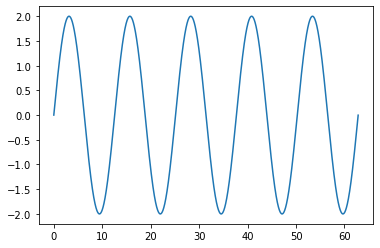

In [27]:
import tensorcircuit as tc
import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

X = tc.gates._x_matrix  
Y = tc.gates._y_matrix  
Z = tc.gates._z_matrix

P_1 = X
P_2 = Y

def f(theta):
    C = np.exp(-1j*theta*P_1/2)
    D = np.exp(1j*theta*P_1/2)
    g = C @ P_2 @ D
    return g[0][0]

y=0.00001
for x in range(30):
    a = (f(x+y)-f(x))/y
    print(a)
    
theta_list = np.arange(0, 20* np.pi, 0.01)
plt.plot(theta_list, [f(theta) for theta in theta_list])
plt.show()

### 1.3.4梯度下降

In [29]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
x=1
z=0.000001
def  f(u):
    t=np.cos(u)*p2+1j*np.sin(u)*p3
    return 1j*t[0][0]
def grad(u):
    return ((f(u+z)-f(u-z))/(2*z))
def find(now):
    u=0.000000001
    if grad(now)*grad(now+u)<0: return 0
    if grad(now)<0 :
        while grad(now+u)<0: 
            u=u*1.5
        now=now+u
    else:
        while grad(now-u)>0:
            u=u*1.5
        now=now-u
    print(f(now))
    find(now)
    
p1=np.array([[0,1],[1,0]])
p2=np.array([[0,-1j],[1j,0]])
p3=np.array([[1,0],[0,1]])

now=70;
print(f(now))
find(now)

(-0.7738906815578891+0j)
(-0.9636113403971079+0j)
(-0.9999182117651416+0j)
(-0.999992794404976+0j)
(-0.9999993748588182+0j)
(-0.9999999428951395+0j)
(-0.9999999956297544+0j)
(-0.9999999994102639+0j)
(-0.9999999999937579+0j)
(-0.9999999999989421+0j)
(-0.9999999999999998+0j)
(-1+0j)
(-1+0j)
(-1+0j)
(-1+0j)


### 1.3.5回到线路

In [32]:
import numpy as np
import tensorcircuit as tc
import math

theta = math.pi / 2
K = tc.set_backend("tensorflow")

def f(theta):
    c = tc.Circuit(1)
    rx = tc.gates.rx_gate(theta)
    ry = tc.gates.ry_gate(theta)
    rz = tc.gates.rz_gate(theta)
    return c.expectation([rx,[0]])

vgf = K.value_and_grad(f)
theta = tc.backend.convert_to_tensor(math.pi)
vgf(theta)

(<tf.Tensor: shape=(), dtype=complex64, numpy=(-4.371139e-08+0j)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.5>)

Text(0.5, 0, 'training step')

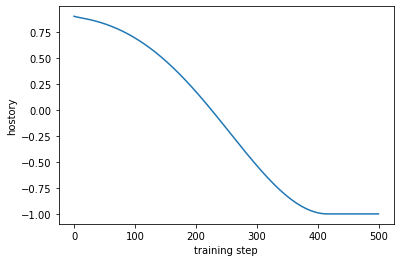

In [34]:
import tensorflow as tw
theta = tc.backend.convert_to_tensor(0.9)

history = []
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

for _ in range(500):
    v, g = vgf(theta)
    theta = opt.update(g, theta)  
    history.append(v)

plt.plot([i for i in range(500)], history)
plt.ylabel("hostory")
plt.xlabel("training step")

## 1.4量子线路

### 1.4.1态生成

01目标为：$$|00……\rangle\rightarrow|00……\rangle+|11……\rangle$$
$$|00……\rangle\stackrel{H}{\longrightarrow}(|0 \rangle+|1 \rangle)|00……\rangle \stackrel{CNOT_{01}}{\longrightarrow} (|00\rangle+|11\rangle)|00……\rangle\stackrel{CNOT_{0n}}{\longrightarrow}|00……\rangle+|11……\rangle$$

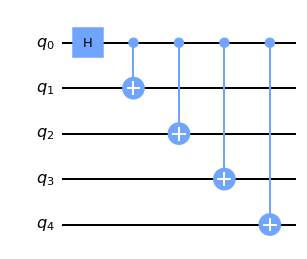

In [19]:
from functools import partial
import inspect
import sys
import numpy as np
import tensorflow as tf

import tensorcircuit as tc

def get_circuit(n):
    c = tc.Circuit(n) 
    c.H(0) 
    for i in range(n-1):
        c.cnot(0,i+1)    
    return c

c1 = get_circuit(5)
c1.draw(output='mpl')

In [17]:
print(c1.state())

[0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710677+0.j]


02目标为：$$\sum_{i=0}^{2^n-1}|i\rangle = (|0\rangle + |1\rangle)\otimes(|0\rangle + |1\rangle)\otimes(|0\rangle + |1\rangle)……$$

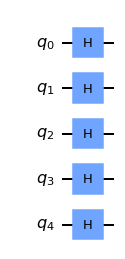

In [4]:
from functools import partial
import inspect
import sys
import numpy as np
import tensorflow as tf

import tensorcircuit as tc

n = 5
def get_circuit(n):
    c = tc.Circuit(n)  # 用 n 个量子比特初始化一个电路对象
    for i in range(n):
        c.H(i)  # 在每个量子比特上使用 Hadamard 门
    return c
get_circuit(n).draw(output='mpl')

03目标为：$$|00……\rangle\rightarrow（U_1+U_2)|0\rangle$$
思路：$$|00……\rangle\stackrel{H}{\longrightarrow}|00……\rangle(|0\rangle+|1\rangle)\stackrel{X_1CU_1X_1\cdot CU_2}{\longrightarrow}|U_10\rangle+|U_21\rangle\stackrel{H}{\longrightarrow}（U_1+U_2)|0\rangle+（U_1-U_2)|1\rangle\stackrel{Measurement}{\longrightarrow}（U_1+U_2)|0\rangle$$

In [ ]:
from functools import partial
import inspect
import sys
import numpy as np
import tensorflow as tf

import tensorcircuit as tc

def get_circuit(n):
    c = tc.Circuit(n)  # 用 n 个量子比特初始化一个电路对象
    c.H(n)

### 1.4.2多比特下的参数平移

In [ ]:
def exp_sumz(n, nlayers, param):
    c = tc.Circuit(n)
    for j in range(nlayers):
        for i in range(n):
            c.rx(i, theta=param[i, j])
        for i in range(n - 1):
            c.cnot(i, i + 1)
    return K.real(K.sum([c.expectation_ps(z=[i]) for i in range(n)]))

### 1.4.3量子门分解

01目标：用cnot门实现swap门，即满足：
$$|00\rangle\rightarrow|00\rangle,|01\rangle\rightarrow|10\rangle,|10\rangle\rightarrow|01\rangle,|11\rangle\rightarrow|11\rangle$$
其中：$$|00\rangle\stackrel{cnot}{\longrightarrow}|00\rangle$$
$$|01\rangle\stackrel{cnot_{1,0}}{\longrightarrow}|11\rangle\stackrel{cnot_{0,1}}{\longrightarrow}|10\rangle$$
$$|10\rangle\stackrel{cnot_{0,1}}{\longrightarrow}|11\rangle\stackrel{cnot_{1,0}}{\longrightarrow}|01\rangle$$
$$|11\rangle\stackrel{cnot}{\longrightarrow}|10\rangle\stackrel{cnot}{\longrightarrow}|11\rangle$$

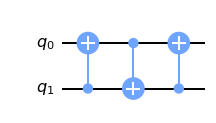

In [4]:
import tensorcircuit as tc
c = tc.Circuit(2)
c.cnot(1,0)
c.cnot(0,1)
c.cnot(1,0)
c.draw(output='mpl')

02用cnot门和Rz单比特门实现双比特门Rzz

### 1.4.4线路解释

In [6]:
import numpy as np
def hmtest(s, u):
    np.testing.assert_allclose(
        np.conj(u) @ np.transpose(u), np.eye(u.shape[-1]), atol=1e-6
    )
    input_state = np.kron(np.array([1, 0]), s)
    n = int(np.log(s.shape[-1]) / np.log(2))
    c = tc.Circuit(n + 1, inputs=input_state)
    c.H(0)
    c.multicontrol(*range(n + 1), ctrl=[1], unitary=u)
    c.H(0)
    return c.expectation_ps(z=[0])


hmtest(
    np.array([1.0, 0, 0, 0]),
    np.kron(np.array([[1.0, 0], [0, -1]]), np.array([[1.0, 0], [0, -1]])),
)

array(0.9999999+0.j, dtype=complex64)

Z = 